In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X_train = np.load('../X_train.npy')
Y_train = np.load('../Y_train.npy')

In [3]:
def normalize_data(data): 
    for i in data:
        i = i / i.max()
    return data

X_train = normalize_data(X_train)
print('Image dataset have shape =', X_train.shape)
Y_train = np.array(Y_train)
print('Train label has shape =', Y_train.shape)

Image dataset have shape = (7726, 700, 700)
Train label has shape = (7726,)


In [4]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
print('Image dataset have shape =', X_train.shape)

Image dataset have shape = (7726, 700, 700, 1)


In [5]:
unique, counts = np.unique(Y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2682, 1: 5044}


In [6]:
transform = transforms.Compose(
 [transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
tensor_x = torch.stack([torch.Tensor(i) for i in X_train])
tensor_y = torch.from_numpy(Y_train)

In [8]:
trainset = utils.TensorDataset(tensor_x,tensor_y) 
trainloader = utils.DataLoader(trainset,  batch_size=55)

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

cpu


In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
images = images.permute(0, 3, 1, 2)
print(images.size())

torch.Size([55, 700, 700, 1])
torch.Size([55, 1, 700, 700])


In [11]:
def poisson_noise(X_torch):
    X = X_torch.cpu().numpy()
    vals = len(np.unique(X))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(X * vals) / float(vals)
    return noisy

def speckle_noise(X_torch):
    X = X_torch.cpu().numpy()
    X = X.reshape((X.shape[0], X.shape[1])) 
    row,col = X.shape
    s_vs_p = 0.5
    amount = 0.02
    out = np.copy(X)
    num_salt = np.ceil(amount * X.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in X.shape]
    out[coords] = 1
    num_pepper = np.ceil(amount* X.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in X.shape]
    out[coords] = 0
    return out.reshape((out.shape[0], out.shape[1],1))

def flip_2D(X_torch):
    return np.fliplr(X_torch.cpu().numpy())

In [12]:
def augment_batch(inputs, labels):
    x = np.zeros((inputs.size()[0]*3,inputs.size()[1],inputs.size()[2], inputs.size()[3]))
    y = np.zeros((labels.size()[0]*3))
    for i in range(len(inputs)):
        x[3*i] = inputs[i].cpu().numpy()
        y[3*i] = labels[i].cpu().numpy()
        x[3*i+1] = flip_2D(inputs[i])
        y[3*i+1] = labels[i]
        if (i%2 == 0):
            x[3*i+2] = poisson_noise(inputs[i])
            y[3*i+2] = labels[i]
        else:
            x[3*i+2] = speckle_noise(inputs[i])
            y[3*i+2] = labels[i]
    return torch.from_numpy(x), torch.from_numpy(y)

In [13]:
num_classes = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((2, 2))
        self.conv3 = nn.Conv2d(20, 10, 4, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(10, 20, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(20, 10, 4, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((2, 2))
        self.conv6 = nn.Conv2d(10, 20, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv7 = nn.Conv2d(20, 10, 4, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv8 = nn.Conv2d(10, 20, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((2, 2))
        self.conv9 = nn.Conv2d(20, 20, 3, padding=1)
        self.pool = nn.MaxPool2d((2, 2))
        self.fc1 = nn.Linear(20, 10)
        self.fc2 = nn.Linear(10, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.float())))
        x = self.pool(F.relu(self.conv2(x.float())))
        x = self.pool(F.relu(self.conv3(x.float())))
        x = self.pool(F.relu(self.conv4(x.float())))
        x = self.pool(F.relu(self.conv5(x.float())))
        x = self.pool(F.relu(self.conv6(x.float())))
        x = self.pool(F.relu(self.conv7(x.float())))
        x = self.pool(F.relu(self.conv8(x.float())))
        x = self.pool(F.relu(self.conv9(x.float())))
        x = x.view(x.size(0), 20)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [14]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(20, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(20, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [15]:
loss_func = nn.CrossEntropyLoss()

In [16]:
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [17]:
avg_losses = []
epochs = 1000 
print_freq = 2

In [19]:
for epoch in range(epochs): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        inputs, labels = augment_batch(inputs, labels)
        
        inputs = inputs.permute(0, 3, 1, 2)
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels.long())

        loss.backward()

        opt.step()
        
        running_loss += loss.item()
        if i % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

/Users/dwei/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/dwei/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


torch.Size([165, 20, 1, 1])
torch.Size([165, 20])
torch.Size([165, 10])
torch.Size([165, 20, 1, 1])
torch.Size([165, 20])
torch.Size([165, 10])
[epoch: 0, i:     1] avg mini-batch loss: 0.695
torch.Size([165, 20, 1, 1])
torch.Size([165, 20])
torch.Size([165, 10])


KeyboardInterrupt: 

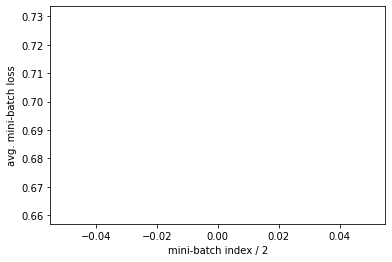

In [20]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [21]:
net.eval()
correct = 0
total = 0

In [22]:
X_test = np.load('../X_test.npy')
Y_test = np.load('../Y_test.npy')

In [23]:
X_test = normalize_data(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [24]:
tensor_x_test = torch.stack([torch.Tensor(i) for i in X_test]) 
tensor_y_test = torch.from_numpy(Y_test)
testset = utils.TensorDataset(tensor_x_test,tensor_y_test)
testloader = utils.DataLoader(testset,  batch_size= 55)

In [25]:
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.S

In [26]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

In [28]:
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(55):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.S

IndexError: index 35 is out of bounds for dimension 0 with size 35

In [29]:
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])
torch.Size([55, 20, 1, 1])
torch.Size([55, 20])
torch.Size([55, 10])


KeyboardInterrupt: 